# Contract Price Model

The input parameters that should be taken into account for pricing are:

1. Injection dates
2. Withdrawal dates
3. The rate at which the gas can be injected/withdrawn
4. The maximum volume that can be stored
5. Storage costs
6. The prices at which the commodity can be purchased/sold on those dates

`price_contract()` is a function that takes these inputs and gives back the value of the contract. <br>
You can assume there is no transport delay and that interest rates are zero. <br>
Market holidays, weekends, and bank holidays need not be accounted for. <br>

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
df = pd.read_csv('Forecast.csv',
                index_col = 0, parse_dates = True)
df.head()

,Prices
2020-10-31,10.100000
2020-11-01,10.106667
2020-11-02,10.113333
2020-11-03,10.120000
2020-11-04,10.126667


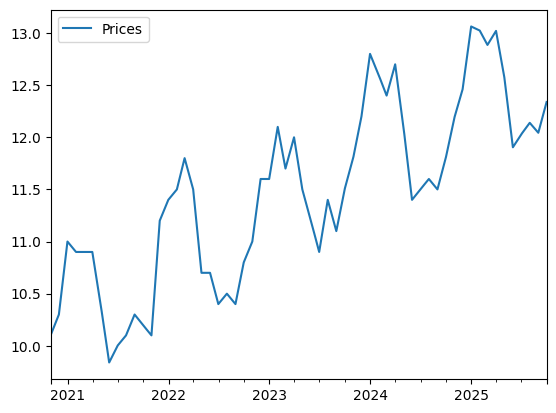

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
df.plot()
plt.show()

### Contract Pricing Function

In [5]:
import math

In [6]:
def negative(volume):
    return -1*volume

In [7]:
def make_df(injections, withdrawals):
    transactions = pd.DataFrame({'Dates' : list(injections.keys()),
                                'Volume' : list(injections.values())})
    withdraw_data = pd.DataFrame({'Dates' : list(withdrawals.keys()), 'Volume' : list(withdrawals.values())})
    withdraw_data['Volume'] = withdraw_data['Volume'].apply(negative)
    transactions = pd.concat([transactions, withdraw_data])
    transactions['Dates'] = pd.to_datetime(transactions['Dates'])
    return (transactions.sort_values(by = ['Dates'])).reset_index().drop(columns = ['index'])

In [8]:
def price_contract(injections, withdrawals, inject_withdraw_rate, max_vol, storage_cost, prices = df, present_vol = 0, contract_price = 0):
    
    transactions = make_df(injections, withdrawals)
    transactions.set_index('Dates', inplace = True)
    stored = False
    storage_price = 0
    purchase_price = 0
    selling_price = 0
    inject_withdraw_cost = 0
    vol_sold = 0
    vol_purchased = 0
    
    for i in transactions.index:
        given_volume = transactions.loc[i]['Volume']
        # Check for volume sign : +ve for Injection, -ve for Withdrawal
        if (given_volume > 0):
            # Check if volume is available
            if (max_vol == present_vol):
                print('Maximum Volume Stored.')
                continue
            elif (max_vol-present_vol) >= given_volume:
                # Buy Gas with Given Volume
                volume = given_volume
            else:
                # Buy Gas with Left Volume
                volume = max_vol-present_vol

            if (not stored):
                first_date = i
                stored = True
        
            # Buying Price
            contract_price -= volume*(prices.loc[i]['Prices'])
            purchase_price += volume*(prices.loc[i]['Prices'])
            # Update Stored Volume 
            present_vol += volume
            vol_purchased += volume
            # Injection Cost
            contract_price -= volume*inject_withdraw_rate
            inject_withdraw_cost += volume*inject_withdraw_rate
            
            continue
        
        # If Gas is Sold
        elif (given_volume < 0):
            # Check if volume is available
            if (present_vol == 0):
                print('Storage Empty')
                # Storage Cost
                if (stored):
                    last_date = i
                    stored = False
                    stored_time = math.ceil(((last_date-first_date).days)/30)
                    contract_price -= stored_time*storage_cost
                    storage_price += stored_time*storage_cost
                
                continue
            elif present_vol >= abs(given_volume):
                # Sell Gas of Given Volume
                volume = abs(given_volume)
            else:
                # Sell Gas of Remaining Volume
                volume = present_vol
            
            # Selling Price
            contract_price += volume*(prices.loc[i]['Prices'])
            selling_price += volume*(prices.loc[i]['Prices'])
            # Update Stored Volume
            present_vol -= volume
            vol_sold += volume
            # Withdrawal Cost
            contract_price -= volume*inject_withdraw_rate
            inject_withdraw_cost += volume*inject_withdraw_rate

            continue

    # End of Loop

    # Storage Cost
    last_date = i
    stored_time = math.ceil(((last_date-first_date).days)/30)
    contract_price -= stored_time*storage_cost
    storage_price += stored_time*storage_cost

    print('''
    
    Total Natural Gas Purchased:      {} million MMBtu
    Total Natural Gas Sold:           {} million MMBtu

    CONTRACT PRICE BREAKDOWN
    ------------------------------------------------------
    Total Cost of Purchase:           {} million USD
    Total Selling Price:              {} million USD
    Total Storage Costs:              {} million USD
    Total Injection/Withdrawal Costs: {} million USD
    ------------------------------------------------------
    Total Contract Profits:           {} million USD
    '''.format(
        vol_purchased,
        vol_sold,
        round(purchase_price,3),
        round(selling_price,3),
        round(storage_price,3),
        round(inject_withdraw_cost,3),
        round(contract_price,3)
    ))
    
    return round(contract_price,3)
    

**NOTE:**
 - The Volume is in 1 million MMBtu units.
 - The Prices are in 1 million USD units.

In [9]:
purchase_dates = {
    '2022-06-30' : 5,
    '2023-06-30' : 3
}

In [10]:
withdrawal_dates = {
    '2023-01-31' : 4.5,
    '2023-12-31' : 2,
    '2024-03-31' : 1.5
}

In [11]:
inject_withdraw_rate = 0.01 # Equivalent to $10K per million MMBtu of Natural Gas
max_vol = 10                # Equivalent to 10 million MMBtu of Natural Gas
storage_cost = 0.1          # Equivalent to $100K per month storage cost
price_contract(purchase_dates, withdrawal_dates, inject_withdraw_rate, max_vol, storage_cost)


    
    Total Natural Gas Purchased:      8.0 million MMBtu
    Total Natural Gas Sold:           8.0 million MMBtu

    CONTRACT PRICE BREAKDOWN
    ------------------------------------------------------
    Total Cost of Purchase:           84.7 million USD
    Total Selling Price:              99.1 million USD
    Total Storage Costs:              2.2 million USD
    Total Injection/Withdrawal Costs: 0.16 million USD
    ------------------------------------------------------
    Total Contract Profits:           12.04 million USD
    


12.04